In [300]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import plot_importance

## 讀取資料

In [301]:
df = pd.read_csv("./dataset/student_scores_clean.csv")

print("All students data shape:", df.shape)
sex = "all"

All students data shape: (2000, 30)


In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   id                            2000 non-null   int64
 1   gender                        2000 non-null   int64
 2   part_time_job                 2000 non-null   int64
 3   absence_days                  2000 non-null   int64
 4   extracurricular_activities    2000 non-null   int64
 5   weekly_self_study_hours       2000 non-null   int64
 6   math_score                    2000 non-null   int64
 7   history_score                 2000 non-null   int64
 8   physics_score                 2000 non-null   int64
 9   chemistry_score               2000 non-null   int64
 10  biology_score                 2000 non-null   int64
 11  english_score                 2000 non-null   int64
 12  geography_score               2000 non-null   int64
 13  career_Accountant             200

In [304]:
career_columns = [col for col in df.columns if col.startswith("career_")]

features = [
    "part_time_job",
    "absence_days",
    "extracurricular_activities",
    "weekly_self_study_hours"
] + career_columns


print("Features num:", len(features))

Features num: 21


## 切分科目

In [305]:
X = df[features]

subject = "geography"  # Change this to the subject you want to predict
# math
# history
# physics
# chemistry
# biology
# english
# geography

y = df[subject+ "_score"]


## 設定模型

In [306]:
model_select = "lr"  # Change this to the model you want to use
# xgb
# lr
# rfr

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [308]:
if model_select == "xgb":
    param_grid = {
        'n_estimators': [100, 300],
        'max_depth': [2, 4, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [0.1, 1]
    }

    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("最佳參數組合 (Best parameters):")
    print(grid_search.best_params_)

    print("最佳模型的負 RMSE (Best negative RMSE):")
    print(grid_search.best_score_)

    best_model = grid_search.best_estimator_

if model_select == "lr":
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    best_model = lr_model
    
if model_select == "rfr":
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    best_model = rf_model

with open(f'{sex}_result/model/{model_select}_{subject}_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

                         Feature  Importance
9                career_Designer    4.969713
5                  career_Artist    4.759458
7          career_Business Owner    2.765768
16      career_Software Engineer   -2.743914
14  career_Real Estate Developer    2.588132
13                 career_Lawyer   -2.344166
19                career_Unknown   -2.233627
8   career_Construction Engineer   -2.130452
15              career_Scientist   -2.075424
10                 career_Doctor    2.063480
6                  career_Banker   -1.971876
18                career_Teacher    1.889832
4              career_Accountant   -1.873400
17         career_Stock Investor   -1.577419
11         career_Game Developer   -1.117042
0                  part_time_job   -0.969899
20                 career_Writer   -0.896685
2     extracurricular_activities   -0.430960
3        weekly_self_study_hours    0.231330
1                   absence_days    0.107834
12     career_Government Officer   -0.072376


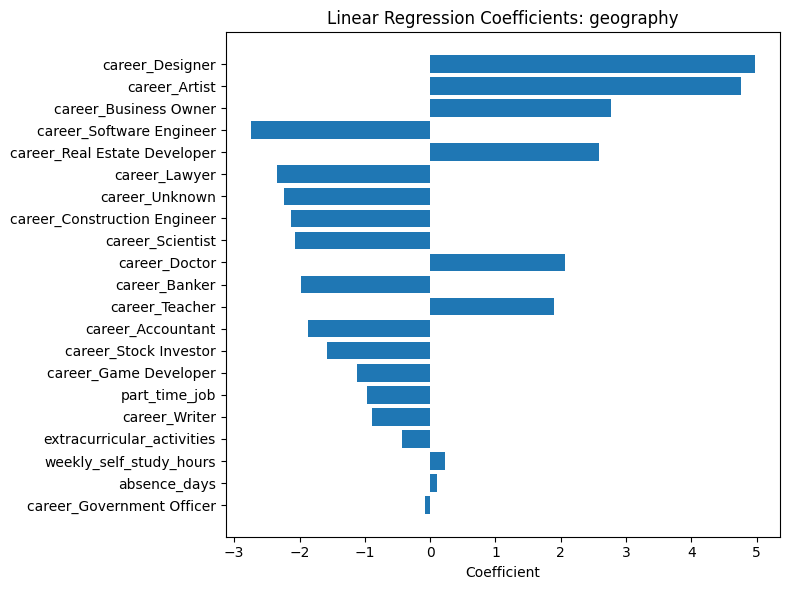

In [309]:
importances = None
title = ""

if model_select == "lr":
    importances = best_model.coef_
    title = f'Linear Regression Coefficients: {subject}'

elif model_select == "xgb":
    # 使用 gain 方式計算 feature importance
    booster = best_model.get_booster()
    score = booster.get_score(importance_type='gain')  # 字典形式

    # 確保所有欄位都有值，即使沒被使用也給 0
    importances = [score.get(f, 0.0) for f in X_train.columns]
    title = f'XGBoost Feature Importances (gain): {subject}'

elif model_select == "rfr":
    importances = best_model.feature_importances_
    title = f'Random Forest Feature Importances: {subject}'

# 建立 DataFrame，並根據絕對值排序取前 21 名
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})
importance_df = importance_df.reindex(importance_df['Importance'].abs().sort_values(ascending=False).index)

print(importance_df.head(21))

# 繪圖
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'][:21][::-1], importance_df['Importance'][:21][::-1])
plt.xlabel('Coefficient' if model_select == 'lr' else 'Importance (gain)' if model_select == 'xgb' else 'Importance')
plt.title(title)
plt.tight_layout()
plt.savefig(f"{sex}_result/feature_importance/{model_select}_{subject}.png", dpi=300)
plt.show()


## 預測結果

In [310]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}") # 0~正無限大(越小越好)
print(f"MAE: {mae:.2f}") # 0~正無限大(越小越好)
print(f"R² 分數: {r2:.4f}") # 負無限大~1 (接近1越好)
print(f"RMSE: {rmse:.2f}") # 0~正無限大(越小越好)

MSE: 135.19
MAE: 9.93
R² 分數: 0.0626
RMSE: 11.63


In [311]:
mean_score = y_test.mean()
error_pct = rmse / mean_score * 100
print(f"相對誤差: {error_pct:.2f}%")

相對誤差: 14.32%


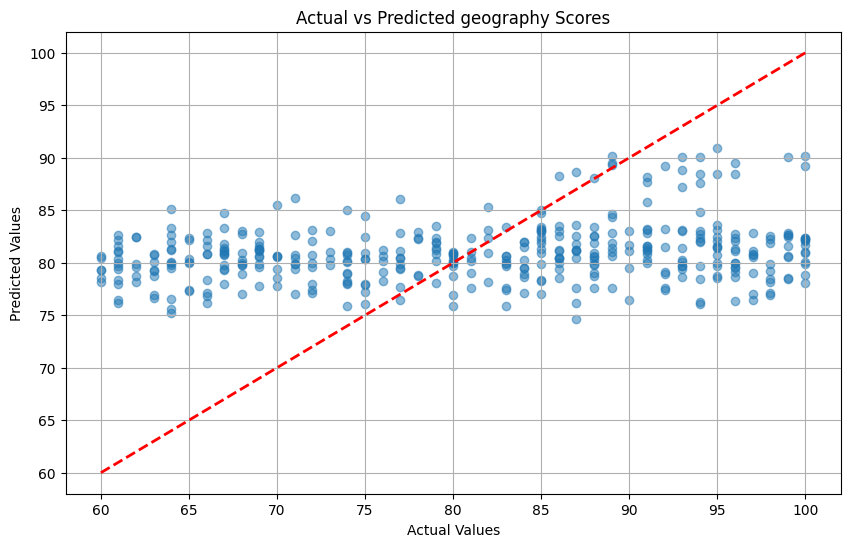

In [312]:
# 繪製實際值與預測值的散點圖
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Actual vs Predicted {subject} Scores')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.savefig(f"{sex}_result/actual_vs_predict/{model_select}_{subject}_scores.png", dpi=300, bbox_inches='tight')
plt.show()